In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[0] 
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


4
Sat Nov 11 22:13:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   30C    P0    63W / 300W |  31973MiB / 32510MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A 

In [24]:
import argparse
import json
import pickle
import string
import time

import numpy as np
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sklearn.cluster import KMeans, AgglomerativeClustering
import torch
from tqdm import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

In [31]:
model_name_or_path = 'results/baselines/sentence-transformers/all-mpnet-base-v2'

input_file = 'data/processed/sharegpt/sharegpt_data.jsonl'
input_file = 'data/processed/ultrachat/ultrachat_data.jsonl'
input_file = 'data/processed/wizardlm/wizardlm_data.jsonl'
n_clusters = 1000
batch_size = 128

role_type = 'user'

In [23]:

model = AutoModel.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)


In [8]:
ds = load_dataset('json', data_files={'train': input_file}, split='train',
                  cache_dir=os.path.dirname(input_file))

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/wizardlm/json/default-34049f801c9d0993/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


In [9]:
def compute_tok_len(example):
    input_ids = tokenizer([x['content'] for x in example['messages']]).input_ids
    lens = [len(x) for x in input_ids]
    numtoks_input = 0
    numtoks_output = 0
    for i, x in enumerate(input_ids):
        if i%2==0: numtoks_input += len(x)
        else: numtoks_output += len(x)
    numtoks_total = numtoks_input+numtoks_output
    example.update({'numtoks': lens,
                    'numtoks_input': numtoks_input, 
                    'numtoks_output': numtoks_output,
                    'numtoks_total': numtoks_total,})
    return example
ds = ds.map(compute_tok_len, num_proc=64)

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/wizardlm/json/default-34049f801c9d0993/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-02216911b13a602c_*_of_00064.arrow


In [30]:

def extract_tokens_for_role_type(example):
    i = 0 if role_type == 'user' else 1
    text = example['messages'][0]['content']
    example.update{'text': text}
    
    return example

ds = ds.map(extract_tokens_for_role_type, num_proc=64)

{'dataset': 'wizardlm',
 'id': 'wizardlm_heR0vZB',
 'messages': [{'role': 'user',
   'content': 'As an online platform teacher named Aimee, you possess impeccable credentials which include a Bachelor of Science degree in Industrial and Labor Relations from Cornell University, expertise in the English language, and intermediate proficiency in both Chinese and Spanish. Additionally, your professional experience as a STEAM teacher at UN Women in Singapore has honed your skills in teaching children from the ages of 6-11 and working with students from all levels of education. Your exceptional teaching abilities in spoken English and pronunciation paired with your personal strengths of being informed, patient, and engaging make you an ideal teacher for students seeking to improve their English language skills. Can you provide a short, concise, and unique English self-introduction in bullet point form that would attract students to enroll in your course?'},
  {'role': 'assistant',
   'content

In [29]:
ds.set_format(type='torch', output_all_columns=False, columns=[''])
ds

Dataset({
    features: ['dataset', 'id', 'messages', 'numtoks', 'numtoks_input', 'numtoks_output', 'numtoks_total'],
    num_rows: 143000
})

In [22]:

loader = DataLoader(ds, shuffle=False, batch_size=batch_size, pin_memory=True) 


104

In [28]:



for i, batch in tqdm(enumerate(loader), total=len(loader)):
    batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}

    break
#     with torch.inference_mode():
#         outputs = model(**batch, output_hidden_states=True)


  0%|          | 0/1118 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'to'

In [16]:


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 
             'Each sentence is converted']


[2023-11-11 22:17:55,378] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [17]:

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')


In [18]:

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print(sentence_embeddings.shape)

torch.Size([2, 768])


In [12]:

embeddings = model.encode(
    texts[:100],
    batch_size=batch_size,
    show_progress_bar=True,
    device="cuda",
    convert_to_tensor=True,
)
embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

NameError: name 'model_name' is not defined

In [11]:


def within_length_bounds_fn(example):
    t = example['messages'][0]['content']
    return (len(t) < args.min_length or len(t) > args.max_length)


dsf = ds.filter(within_length_bounds_fn, num_proc=16)




Filter (num_proc=16):   0%|          | 0/219195 [00:00<?, ? examples/s]

MPNetTokenizerFast(name_or_path='sentence-transformers/all-mpnet-base-v2', vocab_size=30527, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	104: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	30526: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, norm

In [12]:
from note_pruning_analysis import convert_example_to_str

i = 12


t = dsf[i]['messages'][0]['content']
print(convert_example_to_str(0, dsf[i]))
print(len(t))
print(t)

metadata: {
    "dataset": "ultrachat",
    "id": "ultrachat_113",
    "idx": 0,
    "n_turns": 8
}

= USER        =
Here is a piece of text: DUBAI, Aug 26 (Reuters) - Saudi Arabia’s stock market outperformed by a large margin on Sunday, led by petrochemical stocks, as Middle Eastern bourses reopened after a one-week break for the Muslim festival of Eid Al Adha.
The Saudi stock index rose 1.4 percent, although trading volume was the lowest this year as some individual investors had not yet returned from holidays. Gainers outnumbered losers by 146 to 23.
The market has been buoyed this year by inflows of foreign funds in anticipation of Riyadh joining emerging market indexes next year. Recent exchange data indicates those inflows have slowed but not halted as stock valuations have risen.
Petrochemical makers were particularly strong after the Brent oil price rebounded above $75.0 a barrel last week. The top petrochemical firm, Saudi Basic Industries , added 1.8 percent and Saudi Kayan r

NameError: name 't' is not defined

In [30]:
print(under_min_length, above_max_length)

664 32991


In [17]:
from fastchat_topic_clustering import get_embeddings


embeddings = get_embeddings(texts, args.model, args.batch_size)

[2023-11-08 00:02:46,673] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Batches:   4%|▍         | 53/1202 [01:36<34:53,  1.82s/it]

KeyboardInterrupt



Error in callback <bound method AutoreloadMagics.post_execute_hook of <IPython.extensions.autoreload.AutoreloadMagics object at 0x7f19c4a4e590>> (for post_execute):


KeyboardInterrupt: 

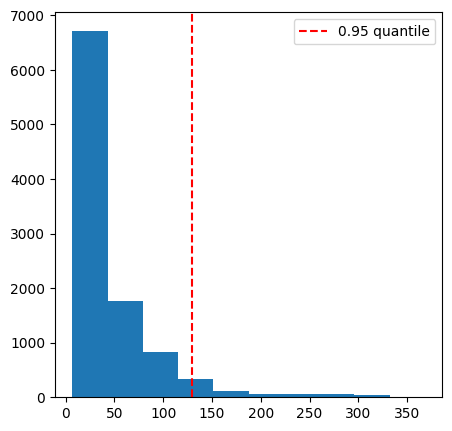

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.hist(lens)

q = .95
v = np.quantile(lens, q)
ax.axvline(x=v, color='r', linestyle='--', label=f'{q} quantile')
ax.legend()

In [16]:
from fastchat_topic_clustering import get_embeddings


embeddings = get_embeddings(texts, args.model, args.batch_size)
if args.cluster_alg == "kmeans":
    centers, labels = run_k_means(embeddings, num_clusters)
elif args.cluster_alg == "aggcls":
    centers, labels = run_agg_cluster(embeddings, num_clusters)
elif args.cluster_alg == "HDBSCAN":
    centers, labels = run_hdbscan_cluster(embeddings)
else:
    raise ValueError(f"Invalid clustering algorithm: {args.cluster_alg}")


307563